In [1179]:
#Import library
import os
import numpy as np

#Import library tensorflow dan modul keras yang diperlukan
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Rescaling, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom

#Penjelasan
# layers digunakan untuk menambahkan lapisan ke dalam model
# load_img digunakan untuk memuat gambar
# ImageDataGenerator digunakan untuk melakukan augmentasi pada gambar
# Sequential digunakan untuk membuat model secara berurutan
# Conv2D digunakan untuk membuat lapisan konvolusi
# MaxPooling2D digunakan untuk melakukan pooling pada lapisan konvolusi
# Dense digunakan untuk membuat lapisan fully connected
# Dropout digunakan untuk menghindari overfitting
# Flatten digunakan untuk membuat lapisan menjadi flat (rata) menjadi vektor 1 dimensi


In [1180]:
count = 0 #digunakan untuk menghitung jumlah gambar
dirs = os.listdir(r'D:\Nicolaus Kevin PH\SEMS 5\ML\UAS\train_data')
for dir in dirs:
    files = list(os.listdir(r'D:\Nicolaus Kevin PH\SEMS 5\ML\UAS\train_data/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

Kacang Almond Folder has 100 Images
Kacang Mete Folder has 100 Images
Kacang Tanah Folder has 100 Images
Images Folder has 300 Images


In [1181]:
# Parameter
base_dir = r'D:\Nicolaus Kevin PH\SEMS 5\ML\UAS\train_data' #direktori folder dataset
img_size = 180 #mengubah ukuran gambar menjadi 180
batch = 10 #jumlah sample (gambar) yang akan diproses pada satu kali iterasi
validation_split = 0.1 #data pelatihan yang akan digunakan sebagai data validasi

In [1182]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir, #path direktori, subfolder dianggap sebagai label
    seed=96, #untuk memastikan proses pemisahan data selalu konsisten (random_state)
    image_size=(img_size, img_size), #ukuran gambar diubah (resize) menjadi 180x180 pixel
    batch_size=batch, #jumlah gambar yang akan dikelompokkan 
)

Found 300 files belonging to 3 classes.


In [1183]:
#mendapatkan nama kelas dari dataset 
class_names = dataset.class_names #dataset.class_names akan mengambil daftar nama kelas berdasarkan subfolder di dalam direktori
print("Class Names:", class_names)

###Terdapat code yang hilang disini! lihat modul untuk menemukanya menghitung jumlah gambar untuk train
total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Class Names: ['Kacang Almond', 'Kacang Mete', 'Kacang Tanah']
Total Images: 30
Train Images: 27
Validation Images: 3


In [1184]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

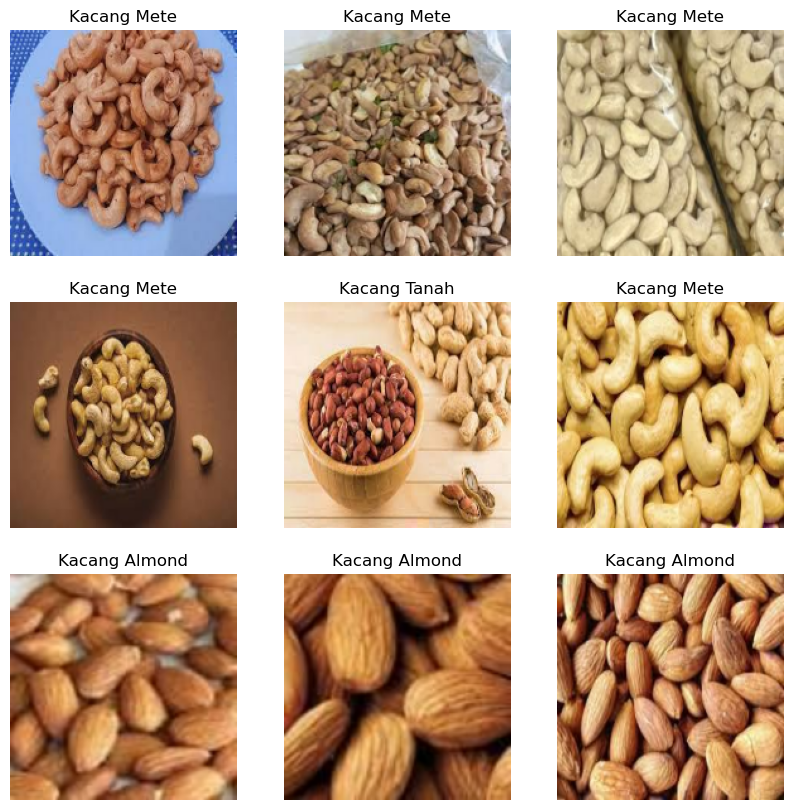

In [1185]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10)) #membuat figure dengan ukuran 10x10 inchi untuk menampilkan gambar

###Terdapat code yang hilang disini! lihat modul untuk menemukanya
for images, labels in train_ds.take(1): #mengambil 1 batch pertama dari train_ds
    for i in range(9):
        plt.subplot(3,3, i+1) #menyiapkan subplot dengan grid 3x3 dan menempatkan gambar pada posisi i+1
        plt.imshow(images[i].numpy().astype('uint8')) #menampilkan gambar dan mengonversi ke tipe uint8
        plt.title(class_names[labels[i]]) #menampilkan judul gambar sesuai dengan nama kelas
        plt.axis('off') #menonaktifkan sumbu pada gambar agar tidak terlihat

In [1186]:
import numpy as np

# Tampilkan gambar dengan shape (32, 180, 180, 3)
for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)  # Output: (32, 180, 180, 3)
    #32: Jumlah gambar dalam batch.
    #180: Lebar gambar dalam piksel
    #180: Tinggi gambar dalam piksel
    #3: Jumlah channel gambar (RGB)

(10, 180, 180, 3)


In [1187]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)), #membalik gambar secara horizontal
    layers.RandomRotation(0.1), #merotasi gambar secara acak dalam kisaran 0°-36° (0.1 * 360)
    layers.RandomZoom(0.1) #melakukan zoom in/zoom out secara acak dengan rentang 10%
])

d:\Tools\Anaconda\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


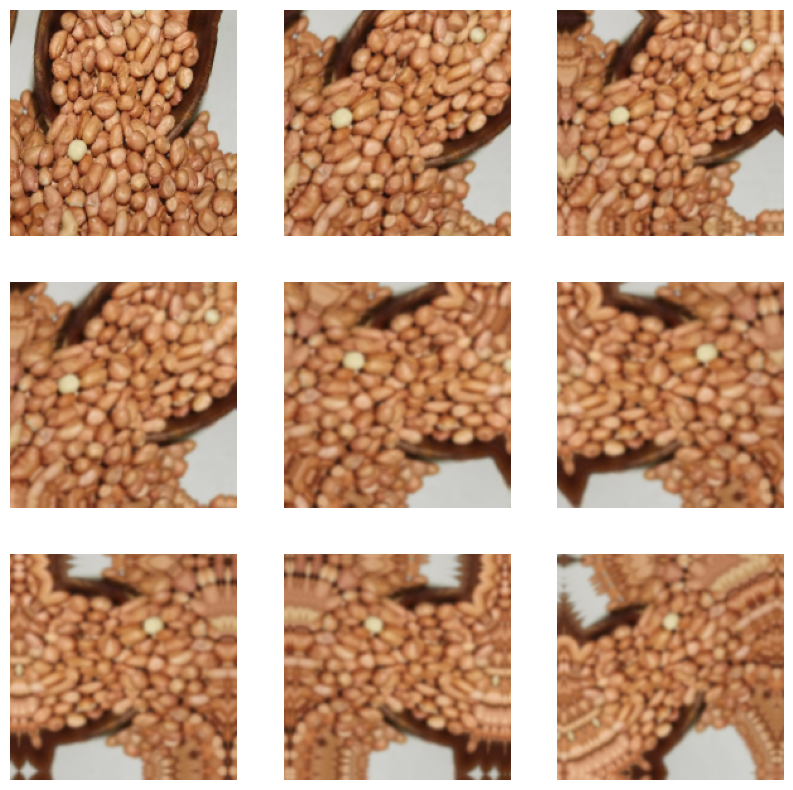

In [1188]:
#sama seperti sebelumnya, code ini digunakan untuk menampilkan gambar dari data_augmentation
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [1189]:
#import library yang dibutuhkan
from tensorflow.keras.applications import MobileNet #digunakan untuk memanfaatkan model yang sudah dilatih sebelumnya untuk pengenalan gambar
from tensorflow.keras.models import Model #digunakan untuk membuat dan mengonfigurasi arsitektur model

#membuat model dengan bobot yang telah dilatih sebelumnya
#include_top=False berarti tidak menggunakan lapisan klasifikasi dari mobilenet hanya bagian ekstraksi fitur
base_model = MobileNet(
    include_top=False,  # Exclude fully connected layers
    input_shape=(img_size, img_size, 3)  # Input shape
)

#membuka (unfreeze beberapa lapisan untuk proses fine tuning)
base_model.trainable = True #seluruh model bisa dilatih
fine_tune_at = len(base_model.layers) // 2  #menentukan bahwa setengah lapisan terakhir akan di unfreeze
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False #mengunci (freeze) lapisan pertama hingga setengah bagian pertama agar tidak dilatih kembali

#membuat model akhir dengan lapisan tambahan
###Terdapat code yang hilang disini! lihat modul untuk menemukanya
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

from tensorflow.keras.optimizers import Adam #untuk mengoptimalkan proses pelatihan model

#mengkompilasi model dengan optimizer, loss function, dan metrics
model.compile(
    optimizer=Adam(learning_rate=1e-4), #menggunakan optimizer Adam dengan learning rate 0.0001
    loss='sparse_categorical_crossentropy', #untuk klasifikasi multi-kelas
    metrics=['accuracy'] #akurasi digunakan sebagai metrik evaluasi
)


C:\Users\M S I\AppData\Local\Temp\ipykernel_21980\469119848.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(


In [1190]:
model.summary()

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_83 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_39 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_36     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,451 (12.82 MB)

 Trainable params: 3,069,443 (11.71 MB)

 Non-trainable params: 291,008 (1.11 MB)

In [1191]:
#early stopping digunakan untuk menghentikan pelatihan lebih awal jika model tidak ada peningkatan
from tensorflow.keras.callbacks import EarlyStopping

#Ada fungsi early stopping disini, jangan keskip tuan :D
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

#melatih model menggunakan data latih dan validasi dengan early stopping
history= model.fit(train_ds, #data pelatihan yang telah disiapkan
                   epochs=30, # jumlah maksimal epoch
                   validation_data=val_ds,  #data validasi untuk mengevaluasi model pada setiap epoch
                   callbacks=[early_stopping]) #menambahkan early stopping ke dalam callback untuk pelatihan

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.5946 - loss: 0.9728 - val_accuracy: 0.2667 - val_loss: 2.8378
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.8898 - loss: 0.3040 - val_accuracy: 0.3000 - val_loss: 2.5967
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9732 - loss: 0.1414 - val_accuracy: 0.6333 - val_loss: 1.1486
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9837 - loss: 0.0875 - val_accuracy: 0.8333 - val_loss: 0.4280
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9628 - loss: 0.0964 - val_accuracy: 0.8667 - val_loss: 0.2373
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9863 - loss: 0.0373 - val_accuracy: 0.9333 - val_loss: 0.1255
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9937 - loss: 0.0385 - val_accuracy: 0.9667 - val_loss: 0.0735
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.9934 - loss: 0.0239 - val_accuracy: 0

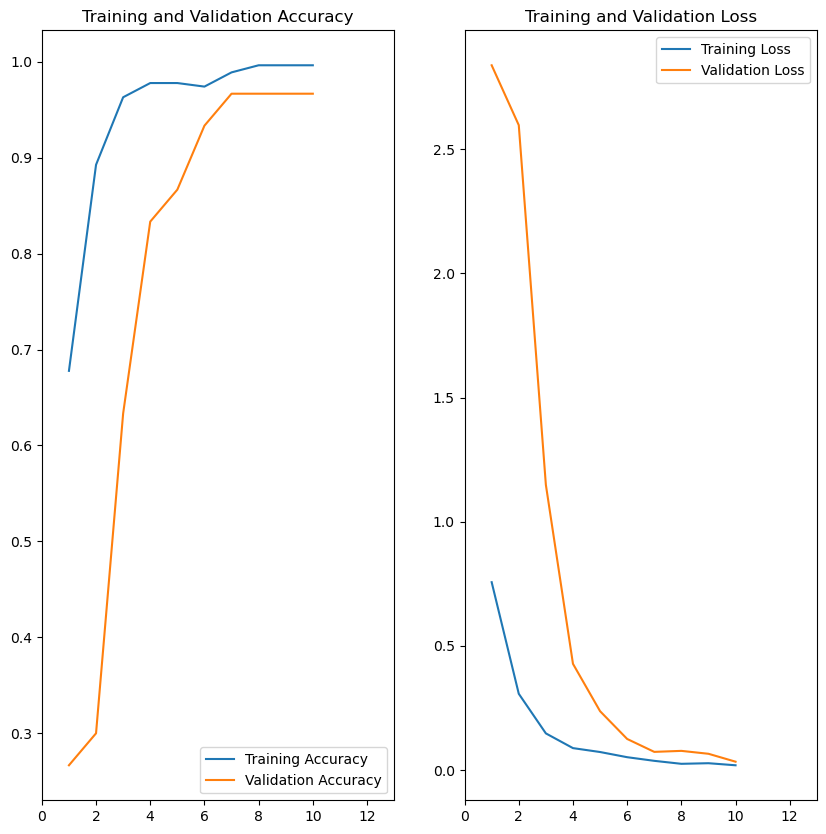

In [1192]:
#membuat range untuk epoch berdasarkan panjang data loss dari pelatihan
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10)) #membuat figure dengan ukuran 10x10 untuk menampilkan 2 grafik (Training and Validation Accuracy dan Loss)

#grafik pertama (Training and Validation Accuracy)
plt.subplot(1, 2, 1) #membuat subplot pertama dalam layout 1 baris dan 2 kolom
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy') #plot akurasi pelatihan 
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy') #plot akurasi validasi
plt.legend(loc='lower right') #membuat legenda (informasi elemen visual) di sudut kanan bawah
plt.xlim(0, 13) #mengatur batas nilai pada sumbu x dari epoch 1 sampai 13
plt.title('Training and Validation Accuracy') #memberi judul grafik

#grafik kedua (Training and Validation Loss)
plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [1193]:
#menyimpan model yang telah dilatih
model.save('BestModel_MobileNet_Numpy.h5')

In [1194]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

#memuat model yang sudah dilatih
model = load_model(r'D:\Nicolaus Kevin PH\SEMS 5\ML\UAS\BestModel_MobileNet_Numpy.h5')  # Ganti dengan path model Anda
class_names = ['Kacang Mete', 'Kacang Almond', 'Kacang Tanah'] #kelas yang ada pada model

#fungsi untuk mengklasifikasikan gambar dan menyimpan gambar asli
def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        #memuat dan mempersiapkan gambar untuk prediksi
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180)) #membuat gambar dari path dan mnegubah ukurannya menjadi 180x180 pixel
        input_image_array = tf.keras.utils.img_to_array(input_image) #mengubah gambar jadi array numpy agar bisa di proses model
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  #menambahkan dimensi batch agar sesuai dengan input model
                                                                    #dimensi menjadi (1, 180, 180, 3)

        #melakukan prediksi
        predictions = model.predict(input_image_exp_dim) #melakukan prediksi pada gambar yang telah diproses
        result = tf.nn.softmax(predictions[0]) #menghitung hasil prediksi menggunakan softmax untuk mendapatkan probabilitas tiap kelas
        class_idx = np.argmax(result) #menemukan indeks kelas dengan probabilitas tertinggi
        confidence = np.max(result) * 100 #menghitung confidence dalam persentase

        #menampilkan hasil prediksi dan confidence
        print(f"Prediksi: {class_names[class_idx]}") #menampilkan nama kelas yang diprediksi 
        print(f"Confidence: {confidence:.2f}%") #menampilkan nilai confidence

        #menyimpan gambar asli tanpa teks
        input_image = Image.open(image_path) #membuka gambar yang ada di path
        input_image.save(save_path) #menyimpan gambar asli ke dalam path yang telah ditentukan

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

#contoh penggunaan fungsi
###Terdapat code yang hilang disini! lihat modul untuk menemukanya
result = classify_images(r'D:\Nicolaus Kevin PH\SEMS 5\ML\UAS\test_data\Validation Kacang Mete\image 3.jpg', save_path='METE.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Prediksi: Kacang Almond
Confidence: 57.02%
Prediksi: Kacang Almond dengan confidence 57.02%. Gambar asli disimpan di METE.jpg.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


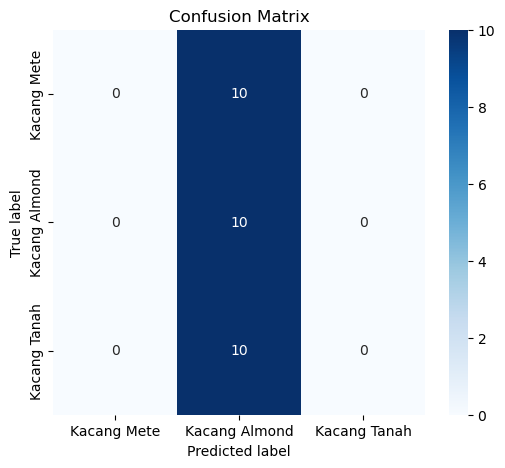

Confusion Matrix:
 [[ 0 10  0]
 [ 0 10  0]
 [ 0 10  0]]
Akurasi: 0.3333333333333333
Presisi: [       nan 0.33333333        nan]
Recall: [0. 1. 0.]
F1 Score: [nan 0.5 nan]


In [1195]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

#memuat model yang telah dilatih sebelumnya
mobileNet_model = load_model(r'D:\Nicolaus Kevin PH\SEMS 5\ML\Pert 13\Tugas6_A_11796\model_mobilenet.h5')#gunakan path masing masing ya

#memuat data test yang sebenarnya
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data', #direktori data uji
    labels='inferred', #label otomatis dari subfolder yang ada
    label_mode='categorical',  #menghasilkan label dalam bentuk one-hot encoding
    batch_size=32, #ukuran batch untuk pemrosesan
    image_size=(180, 180) #ukuran gambar yang akan diproses
)

#prediksi model
y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  #konversi ke kelas prediksi

#ekstrak label sebenarnya dari test_data dan konversi ke bentuk indeks kelas
true_labels = [] #menyimpan label asli dalam bentuk indeks
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())  #konversi one-hot ke indeks kelas
true_labels = tf.convert_to_tensor(true_labels) #mengkonversi list ke tensor untuk perhitungan

#membuat confusion matrix untuk evaluasi
conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

#menghitung akurasi berdasarkan confusion matrix
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

#mnghitung presisi dan recall dari confusion matrix
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

#menghitung F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

#visualisasi Confusion Matrix
plt.figure(figsize=(6, 5)) #mengatur ukuran gambar
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', #annot=True untuk menampilkan angka di dalam setiap sel matriks
                                                                 #fmt='d' untuk menampilkan bilangan bulat tanpa desimal
            xticklabels=['Kacang Mete', 'Kacang Almond', 'Kacang Tanah'], yticklabels=['Kacang Mete', 'Kacang Almond', 'Kacang Tanah'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
